In [1]:
# import things
import KenGP as gp
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons

%load_ext autoreload
%autoreload 2


In [2]:
"""
# These are our constants
N = 5  # Number of variables
F = 8  # Forcing


def L96(x, t):
    #Lorenz 96 model with constant forcing
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, 30.0, 0.01)

x = odeint(L96, x0, t)

# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()
"""

'\n# These are our constants\nN = 5  # Number of variables\nF = 8  # Forcing\n\n\ndef L96(x, t):\n    #Lorenz 96 model with constant forcing\n    # Setting up vector\n    d = np.zeros(N)\n    # Loops over indices (with operations and Python underflow indexing handling edge cases)\n    for i in range(N):\n        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F\n    return d\n\n\nx0 = F * np.ones(N)  # Initial state (equilibrium)\nx0[0] += 0.01  # Add small perturbation to the first variable\nt = np.arange(0.0, 30.0, 0.01)\n\nx = odeint(L96, x0, t)\n\n# Plot the first three variables\nfig = plt.figure()\nax = fig.gca(projection="3d")\nax.plot(x[:, 0], x[:, 1], x[:, 2])\nax.set_xlabel("$x_1$")\nax.set_ylabel("$x_2$")\nax.set_zlabel("$x_3$")\nplt.show()\n'

In [3]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

In [4]:
def delayEmbed(X, Y,assignment,embInterval):
    
    tmplen = X.shape[1]

    tmp = np.zeros([sum(x) for x in zip(X.shape,(0,sum(assignment)))])
    tmp[:,:X.shape[1]] = X
    X = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = X[:-embInterval*lag,i]
                X[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    X = X[embInterval*sum(assignment):]
    
    Y = Y[-X.shape[0]:]
    
    return (X, Y)

In [5]:
begin = 0
end = 30
step = 0.1
tlen = int((end-begin)/step)
trainToTest = 0.8 # between 0 and 1
t = np.arange(begin, end, step)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 5
t0 = 8 * np.ones(5) # np.zeros(dim)
t0[0] += 0.1

In [12]:
# Discrete Time Systems

# Munch Model, includes a time lag explicitly
trueLag = 4
initval = 2
r = 1.75 # vals used are 8, 3.5, 2.5, 1.75
states = np.zeros((tlen,1))
for i in range(tlen):
    if i <= trueLag:
        states[i] = initval
    else: 
        states[i] = r*states[i-1]*np.exp(-states[i-1-trueLag]+rand.normal(0,0.1,1))

plt.show()


In [13]:

# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
# states = odeint(Lorenz96,t0,t)
print(states)
# END STATIONARY SIMULATION

# FROM DATA
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()
print(states)
"""
# END FROM DATA


# NON STATIONARY VERSION
"""
rho = 0.2        # rho = 28.0
sigma = 0.2       # sigma = 10.0
beta = 5.7  # beta = 8.0 / 3.0

deltaP = 0.005
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    states[i] = odeint(RosslerP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]
    sigma += deltaP

# END NON STATIONARY
"""

[[2.     ]
 [2.     ]
 [2.     ]
 [2.     ]
 [2.     ]
 [0.48606]
 [0.12498]
 [0.0273 ]
 [0.00545]
 [0.00142]
 [0.00154]
 [0.00259]
 [0.00439]
 [0.00905]
 [0.01404]
 [0.02052]
 [0.03745]
 [0.06765]
 [0.11103]
 [0.18804]
 [0.35229]
 [0.64151]
 [0.90059]
 [1.40819]
 [1.83157]
 [2.15398]
 [1.76529]
 [1.4348 ]
 [0.59833]
 [0.16268]
 [0.03595]
 [0.01062]
 [0.00516]
 [0.0051 ]
 [0.00922]
 [0.01438]
 [0.02594]
 [0.04325]
 [0.07422]
 [0.13341]
 [0.1999 ]
 [0.3609 ]
 [0.56891]
 [0.95506]
 [1.45485]
 [2.19139]
 [2.58681]
 [2.624  ]
 [1.86667]
 [0.73427]
 [0.15338]
 [0.02019]
 [0.00267]
 [0.00076]
 [0.00064]
 [0.00081]
 [0.00119]
 [0.00197]
 [0.00438]
 [0.00742]
 [0.0132 ]
 [0.02661]
 [0.05103]
 [0.0912 ]
 [0.179  ]
 [0.3151 ]
 [0.64877]
 [0.9592 ]
 [1.79557]
 [3.02298]
 [3.61179]
 [2.96675]
 [2.19238]
 [0.62949]
 [0.05197]
 [0.00212]
 [0.0002 ]
 [0.00004]
 [0.00003]
 [0.00006]
 [0.00011]
 [0.00023]
 [0.00037]
 [0.00077]
 [0.00122]
 [0.00173]
 [0.00337]
 [0.00643]
 [0.01152]
 [0.02108]
 [0.03142]

'\nrho = 0.2        # rho = 28.0\nsigma = 0.2       # sigma = 10.0\nbeta = 5.7  # beta = 8.0 / 3.0\n\ndeltaP = 0.005\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    states[i] = odeint(RosslerP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]\n    sigma += deltaP\n\n# END NON STATIONARY\n'

IndexError: index 1 is out of bounds for axis 1 with size 1

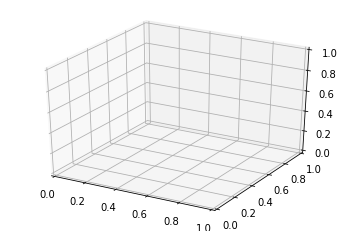

In [14]:
# Normalize, split data
states = (states - states.mean(0) ) / states.std(0) # normalize
testTrainSplit = int(states.shape[0] * trainToTest)

X = states[:-1,:3]
Y = states[1:,]

# Print Input
fig2 = plt.figure(2)
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(X[:,0],X[:,1],X[:,2])
    
np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)
# print(X.flatten())
    
# Xt = np.column_stack((X[testTrainSplit:,], X[testTrainSplit-1:-1,1]))
Xt = X[testTrainSplit:,]
Yt = Y[testTrainSplit:,]
X = X[:testTrainSplit,]
Y = Y[:testTrainSplit,]

plt.show()

In [9]:
# GP setup
gp.setCovar("sqrexp")
# gp.setPrior(1,"half-normal")
#gp.setPrior(2,"half-normal")
gp.setData(X,Y)
gp.setTimeDelayInterval(2)

assignment = [1,1,1]
gp.setTimeDelayEmbedding(assignment)
print(gp.X)
for i in range(4,7):
    gp.setPrior(i,"ARD")
embDim = 4


print(type(X),type(Y),type(assignment))
Xt, Yt = delayEmbed(X,Y,assignment,1)


Prior dict  {0: 'none', 1: 'none', 2: 'none'}
Covariance function set to  sqrexp
Data input success
tmp  (240, 6)
r  [4.69104 4.89306 4.3587 ]
Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none', 4: 'none', 5: 'none'}
New X Dimensions  (234, 6)
[[ 2.02155  0.31582  0.45453  1.58752  1.37218  1.53685]
 [-0.95752 -0.68079  0.54619  2.0884   1.43969  1.52258]
 [-2.60264 -0.5968   1.02929  2.02155  1.65677  1.55399]
 ...
 [ 0.85166  0.26377 -1.52509  0.38402  1.32576  0.60808]
 [ 0.57351 -0.88626 -1.29857  0.61214  1.61861  0.88621]
 [-0.19274 -1.48969 -0.94049  0.85166  1.5473   0.68422]]
Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none', 4: 'ARD', 5: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>


Gradient:  [-0.95012  0.08066 -0.18756  0.18679  0.14023 -0.03212]
Likelihood:  57.322685198158226
Hp:  [0.45 0.62 0.45 0.22 0.22 0.05]  #  1
Gradient:  [-0.97533  0.01353 -0.19937  0.05248  0.03293 -0.07043]
Likelihood:  75.48331476005937
Hp:  [0.39  0.764 0.39  0.364 0.364 0.   ]  #  2
Gradient:  [-0.97141 -0.04244 -0.21209 -0.01544 -0.02397 -0.0936 ]
Likelihood:  95.03831978694087
Hp:  [0.318 0.692 0.318 0.292 0.292 0.   ]  #  3
Gradient:  [-0.99305  0.06475 -0.05306  0.0658   0.04927 -0.00932]
Likelihood:  118.04631254864147
Hp:  [0.2316 0.728  0.2316 0.328  0.328  0.    ]  #  4
Gradient:  [-0.82384  0.16119  0.40655  0.12685  0.12441  0.31377]
Likelihood:  141.75153472051696
Hp:  [0.12792 0.7712  0.2748  0.3712  0.3712  0.0432 ]  #  5
Gradient:  [-0.67549  0.21849  0.60036  0.1226   0.13331  0.32053]
Likelihood:  170.99265568498683
Hp:  [0.0035  0.82304 0.32664 0.42304 0.42304 0.09504]  #  6
Gradient:  [0.01515 0.31614 0.86161 0.17569 0.20144 0.29328]
Likelihood:  185.074408314685

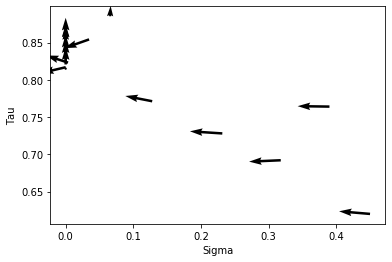

IndexError: index 6 is out of bounds for axis 0 with size 6

In [10]:
# 2.96355967e-05 3.10039090e+00 6.52724514e-03 9.60568331e-01
 #9.60568331e-01 9.60568331e-01
# optimize them parameters
gp.hyperParamOptimize(steps=20, yind=0) # <<<< THIS IS EXPENSIVE

In [11]:
# One step predictions
diffTable = []
predictions = np.zeros((len(Xt),dim))
variances = np.zeros((len(Xt),1))
for i in range(len(Xt)):
    predTuple = gp.predict(Xt[i])
    variances[i] = predTuple[1]
    predictions[i] = predTuple[0] # list of one step prediction values for graphing
    
    diff = la.norm(Yt[i] - predictions[i]) # norm error for 1 step
    diffTable.append(diff)
# print("Predictions ", predictions)
# print("DiffTable ", diffTable)

diffTable = np.array(diffTable)

ValueError: could not broadcast input array from shape (3) into shape (5)

In [ ]:
# feed forward prediction
"""
n = 200 # num steps
feedForwardPrediction = np.zeros(((n,dim)))
feedForwardPrediction[0] = X[0]
for i in range(n-1):
    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]
"""

In [ ]:
fig0 = plt.figure(0)
if dim == 1:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],"b") # states
    ax0.plot(predictions[:,0],'--r')
elif dim == 2:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],Yt[:,1],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],'--r') # map of 1 step ahead predictions
else:
    ax0 = fig0.gca(projection="3d")
    ax0.plot(Yt[:,0],Yt[:,1],Yt[:,2],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],predictions[:,2],'--r') # map of 1 step ahead predictions
    # ax0.plot(feedForwardPrediction[:,0],feedForwardPrediction[:,1],feedForwardPrediction[:,2],'--g') # map of 50 step ahead prediction

fig1 = plt.figure(1)
plt.title("1 step error")
plt.hist(diffTable)

fig2 = plt.figure(2)
plt.hist(variances)
plt.title("GP Variance")

plt.show()

In [ ]:
# This doesn't work in Jupyter lol
fig3 = plt.figure(3)
sliderAx = plt.axes()
slider = Slider(sliderAx,"Tao", 0, 50, valinit=0, valstep=0.1)

fig4 = plt.figure(4)
paramAx = plt.axes()
paramButtons = RadioButtons(paramAx, ("rho","sigma","beta"), active = 0)

def update(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        rho = slider.val
    elif (paramButtons.value_selected == "sigma"):
        sigma = slider.val
    elif (paramButtons.value_selected == "beta"):
        beta = slider.val

    # Line Plot Update
    s = odeint(LorenzP,t0,t, args=(rho,sigma,beta))
    ax2.clear()
    ax2.plot(s[:,0], s[:,1], s[:,2])

    # Quiver Update
    mi = np.nanmin(s,axis=0)
    ma = np.nanmax(s,axis=0)
    st = abs(mi - ma) / 5
    print(st)

    x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
    u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
    ax2.quiver(x,y,z,u,v,w,length=5,normalize=True, color = "r", alpha = 0.25)
    
    fig2.canvas.draw()
    fig2.canvas.flush_events()

def update2(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        slider.set_val(rho)
    elif (paramButtons.value_selected == "sigma"):
        slider.set_val(sigma)
    elif (paramButtons.value_selected == "beta"):
        slider.set_val(beta)

slider.on_changed(update)
paramButtons.on_clicked(update2)

# Quiver Plot
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")


mi = np.nanmin(X,axis=0)
ma = np.nanmax(X,axis=0)
st = abs(mi - ma) / 5
print(st)

x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
ax2.quiver(x,y,z,u,v,w,length=st[0],normalize=True, color = "r", alpha=0.25)

plt.show()